In [1]:
# %matplotlib notebook
%matplotlib inline

import re
import random
import os.path
import fnmatch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy import signal, stats
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

In [2]:
# figure styling
sns.set(style='ticks', palette='colorblind')
figure_path = '/media/turritopsis/katie/grooming/dim_reduction/figures' 
# plt.rcParams['figure.figsize'] = (6,3)
# plt.rcParamsfigure.dpi'] = 200

In [6]:
def get_kde_vals(arr, xvals=None):
    
    x = arr[~np.isnan(arr)]
    kde = stats.gaussian_kde(x, bw_method='scott')
    
    if xvals is None:
        xvals = np.linspace(np.min(x)-1, np.max(x)+1, num=150)
    yvals = kde.evaluate(xvals)
    
    return xvals, yvals

# get the angle names to analyze (use _BC instead of _abduct for now)
def get_angle_names(angles, angle_types, only_t1):
    angle_names = np.array([])
    for ang in angle_types:
        if only_t1:
            angle_names = np.append(angle_names, [s for s in list(angles.columns) if '1' in s and ang in s])
        else:
            angle_names = np.append(angle_names, [s for s in list(angles.columns) if ang in s])
    # angle_names = angle_names + ['fictrac_speed', 'fictrac_rot']
    angle_names = [x for x in angle_names if 'freqs' not in x]
    return angle_names

# adjust _rot angles so there are no discontinuities
def adjust_rot_angles(angles, angle_names):
    rot_angs = [r for r in angle_names if '_rot' in r]
    for ang in rot_angs:
        r = np.array(angles[ang])
        r[r > 50] = r[r > 50] - 360
        angles[ang] = r
    return angles

# removes grooming bouts from dataset that are less than a specified 
# number of frames (too short to analyze)
def remove_short_bouts(data, min_frames):    
    bout_numbers = np.unique(data.behavior_bout)
    bout_lengths = np.zeros(bout_numbers.shape)
    for j in range(len(bout_numbers)):
        bout_lengths[j] = len(data[data.behavior_bout == bout_numbers[j]])
        
    saved_bouts = bout_lengths[bout_lengths >= min_frames]
    data_new = data[data.behavior_bout.isin(saved_bouts)]
    
    return data_new

# returns dictionary that maps bout number to fly id
def get_fly_id(angles, bout_numbers):
    fly_id = dict()
    for j in range(len(bout_numbers)):
        bout_df = angles[angles.behavior_bout == bout_numbers[j]]
        fly_id[bout_numbers[j]] = bout_df.iloc[0].flyid
    return fly_id

def norm(X):
    X_norm = X.reshape(X.shape[0], -1)
    X_norm = X - np.mean(X, axis = 0)
    X_norm = X_norm / np.std(X, axis = 0)
    X_norm = X_norm.reshape(X.shape)
    return X_norm

# determine which flies we have the most data for, then sort by flies with the most data
def data_per_fly(data):
    bout_numbers = np.unique(data.behavior_bout)
    fly_ids = get_fly_id(data, bout_numbers)
    fly_data = dict()
    for j in range(len(bout_numbers)):
        fly = fly_ids[bout_numbers[j]]
        bout_length = len(data[data.behavior_bout == bout_numbers[j]])
        if fly not in fly_data:
            fly_data[fly] = 0
        fly_data[fly] += bout_length       
    fly_names_sorted = sorted(fly_data, key=fly_data.get, reverse=True) 
    return fly_data, fly_names_sorted

# time based features
def time_features(data, angles, filenames, label_type, nperseg, noverlap, normalize, only_t1):
    
    X_list = []
    labels_list = [] 
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types, only_t1 = only_t1)
    
    for filename in filenames:
        sub_ixs = angles['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = np.array(angles.loc[sub_ixs, angle_names])
        labels_sub = np.array(angles.loc[sub_ixs, label_type])
    
        unique_labels = np.unique(labels_sub)
        if len(unique_labels) > 1:
            for j in range(len(unique_labels)):
                labels_sub_u = labels_sub[labels_sub == unique_labels[j]]
                X_sub_u = X_sub[labels_sub == unique_labels[j]]
                for i in range(0, X_sub_u.shape[0], noverlap):
                    if X_sub_u.shape[0] > i+nperseg:
                        X_list.append(X_sub_u[i:i+nperseg].T)
                        labels_list.append(labels_sub_u[i+nperseg//2])
        else: 
            for i in range(0, X_sub.shape[0], noverlap):
                if X_sub.shape[0] > i+nperseg:
                    X_list.append(X_sub[i:i+nperseg].T)
                    labels_list.append(labels_sub[i+nperseg//2])
    
    X_times = np.array(X_list)
    labels_times = np.array(labels_list)
    
    if normalize:
        X_times = norm(X_times)
    
    return X_times, labels_times

# assign a unique bout number to each bout (previously had duplicates due
# to running experiments on different days)
def adjust_bout_numbers(data):
    
    dates = np.unique(data.date)
    cumulative_bouts = 1
    data_new = pd.DataFrame()
    
    for i in range(len(dates)):
        
        subset = data[data['date'] == dates[i]]
        bout_numbers = np.unique(subset.behavior_bout)
        bout_numbers_new = np.arange(cumulative_bouts, cumulative_bouts + len(bout_numbers), 1)
        cumulative_bouts = cumulative_bouts + len(bout_numbers)
        
        for j in range(len(bout_numbers)):
            subset['behavior_bout'].replace({bout_numbers[j]:bout_numbers_new[j]}, inplace=True)
            
        data_new = pd.concat([data_new, subset])
    
    return data_new

# time based features
def time_features(data, angles, filenames, label_type, nperseg, noverlap, normalize, only_t1):
    
    X_list = []
    labels_list = [] # remember to append to stft labels
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types, only_t1 = only_t1)
    
    for filename in filenames:
        sub_ixs = data['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = np.array(angles.loc[sub_ixs, angle_names])
        labels_sub = np.array(data.loc[sub_ixs, label_type])
    
        for i in range(0, X_sub.shape[0], noverlap):
            if X_sub.shape[0] > i+nperseg:
                X_list.append(X_sub[i:i+nperseg].T)
                labels_list.append(labels_sub[i+nperseg//2])
    
    X_times = np.array(X_list)
    labels_times = np.array(labels_list)
    
    if normalize:
        X_times = norm(X_times)
    
    return X_times, labels_times

# stft based features
def stft_features(data, angles, filenames, label_type, fps, nperseg, noverlap, normalize, only_t1):

    X_list = []
    labels_list = []
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types, only_t1 = only_t1)
    
    for filename in filenames:
        sub_ixs = data['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = angles.loc[sub_ixs, angle_names]
    
        freqs, times, Z = signal.stft(X_sub, fs=fps, nperseg=nperseg, noverlap=noverlap, axis=0, padded=False, boundary=None)
        Zs = np.log(np.abs(Z.swapaxes(0, 2)))
    
        labels_sub = np.array(data.loc[sub_ixs, label_type])
        labels_sub_down = labels_sub[::noverlap]
        Zs = Zs[:len(labels_sub_down)]
    
        # good = ~pd.isnull(labels_sub_down)
        good = np.arange(len(Zs))
    
        X_list.append(Zs[good])
        labels_list.append(labels_sub_down[good])
    
    X_stft = np.vstack(X_list)
    labels_stft = np.hstack(labels_list)
    
    if normalize:
        X_stft = norm(X_stft)
    
    return X_stft, labels_stft


# get labels according to feature chosen (filename, bout, fly, behavior, etc)
def get_label_dict(labels):
    
    labels_ids = np.zeros(labels.shape, dtype='int32')
    labels_ids[:] = -1 # default for unlabeled data
    
    bad = pd.isnull(labels) | (labels == 'nan')
    labels_types = np.unique(labels[~bad])
    label_dict = dict(zip(labels_types, range(len(labels_types))))
    
    for label, num in label_dict.items():
        labels_ids[label == labels] = num
        
    return label_dict, labels_types, labels_ids

def plot_xmap(X_map, labels, label_types, fly_dict, cmap = 'Spectral', method = ''):
    
    n_components = X_map.shape[1]
    label_dict, labels_types, labels_ids = get_label_dict(labels)
    fig = plt.figure(figsize = (8,4))

    if n_components == 2:
        plt.scatter(X_map[:, 0], X_map[:, 1], c=cmap(labels_ids), s=7)
        plt.scatter(X_map[:, 0], X_map[:, 1], c=labels_ids, cmap = cmap, s=7)
    else if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_map[:, 0], X_map[:, 1], X_map[:, 2], c=cmap(labels_ids), s=7)
        ax.scatter(X_map[:, 0], X_map[:, 1], X_map[:, 2], c=labels_ids, cmap = cmap, s=7)
    
    plt.title(method + ' on T1 grooming joint angles (' + label_types[j] + ')', fontsize = 14)
    plt.xlabel(method + '1', fontsize = 14)
    plt.ylabel(method + '2', fontsize = 14)
    n = len(labels_types)
    if label_types[j] == 'behavior_bout':
        patches = [Patch(color=cmap(i % 20), label = str(x) + ' (' + fly_dict[x] + ')') for i, x in enumerate(labels_types)]
        patches = [Patch(color=cmap(i/(n-0.9999)), label = str(x) + ' (' + fly_dict[x] + ')') for i, x in enumerate(labels_types)]
    else: 
        patches = [Patch(color=cmap(i % 20), label = x) for i, x in enumerate(labels_types)]
        patches = [Patch(color=cmap(i/(n-0.9999)), label = x) for i, x in enumerate(labels_types)]
    plt.legend(handles=patches, bbox_to_anchor = (1, 1))
    plt.show()

In [ ]:
# time based features
def time_features(data, angles, filenames, label_type, nperseg, noverlap, normalize, only_t1):
    
    X_list = []
    labels_list = [] # remember to append to stft labels
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types, only_t1 = only_t1)
    
    for filename in filenames:
        sub_ixs = data['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = np.array(angles.loc[sub_ixs, angle_names])
        labels_sub = np.array(data.loc[sub_ixs, label_type])
    
        unique_labels = np.unique(labels_sub)
        if len(unique_labels) > 1:
            for j in range(len(unique_labels)):
                labels_sub_u = labels_sub[labels_sub == unique_labels[j]]
                X_sub_u = X_sub[labels_sub == unique_labels[j]]
                for i in range(0, X_sub_u.shape[0], noverlap):
                    if X_sub_u.shape[0] > i+nperseg:
                        X_list.append(X_sub_u[i:i+nperseg].T)
                        labels_list.append(labels_sub_u[i+nperseg//2])
                
        else: 
            for i in range(0, X_sub.shape[0], noverlap):
                if X_sub.shape[0] > i+nperseg:
                    X_list.append(X_sub[i:i+nperseg].T)
                    labels_list.append(labels_sub[i+nperseg//2])
    
    X_times = np.array(X_list)
    labels_times = np.array(labels_list)
    
    if normalize:
        X_times = norm(X_times)
    
    return X_times, labels_times

# stft based features
def stft_features(data, angles, filenames, label_type, fps, nperseg, noverlap, normalize, only_t1):

    X_list = []
    labels_list = []
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types, only_t1 = only_t1)

    for filename in filenames:

        sub_ixs = data['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = angles.loc[sub_ixs, angle_names]
    
        freqs, times, Z = signal.stft(X_sub, fs=fps, nperseg=nperseg, noverlap=noverlap, axis=0, padded=False, boundary=None)
        Zs = np.log(np.abs(Z.swapaxes(0, 2)))
    
        labels_sub = np.array(data.loc[sub_ixs, label_type])
        unique_labels = np.unique(labels_sub)
        if len(unique_labels) > 1:
            for j in range(len(unique_labels)):
        
                X_sub_u = X_sub[labels_sub == unique_labels[j]]
                freqs, times, Z = signal.stft(X_sub_u, fs=fps, nperseg=nperseg, noverlap=noverlap, axis=0, padded=False, boundary=None)
                Zs = np.log(np.abs(Z.swapaxes(0, 2)))
                
                labels_sub_u = labels_sub[labels_sub == unique_labels[j]]
                labels_sub_down = labels_sub_u[::noverlap]
                Zs = Zs[:len(labels_sub_down)]
            
                # good = ~pd.isnull(labels_sub_down)
                good = np.arange(len(Zs))
            
                X_list.append(Zs[good])
                labels_list.append(labels_sub_down[good])
        else:                  
            labels_sub_down = labels_sub[::noverlap]
            Zs = Zs[:len(labels_sub_down)]
        
            # good = ~pd.isnull(labels_sub_down)
            good = np.arange(len(Zs))
        
            X_list.append(Zs[good])
            labels_list.append(labels_sub_down[good])
    
    X_stft = np.vstack(X_list)
    labels_stft = np.hstack(labels_list)
    
    if normalize:
        X_stft = norm(X_stft)
    
    return X_stft, labels_stft

In [7]:
# load data
prefix = r'/media/turritopsis/pierre/gdrive/latest/behavior/T1_grooming'
data_path = os.path.join(prefix, 'T1_grooming_all.csv.gz')
data = pd.read_csv(data_path, compression = 'gzip')
data['behavior_bout'] = data['T1_grooming_bout_number']
data['flyid'] = data['fly'].astype(str) + ' ' + data['date'].astype(str)
data = data[~data.behavior_bout.isnull()]
data = adjust_bout_numbers(data)
data = remove_short_bouts(data, 50)

fps = 300.0 # know this for this dataset
only_t1 = True
normalize = True

# behaviors = pd.read_csv(behaviors)

# get the joints to analyze
bodyparts = np.array(['L1A', 'L1B', 'L1C', 'L1D', 'L1E', 
                      'L2A', 'L2B', 'L2C', 'L2D', 'L2E', 
                      'L3A', 'L3B', 'L3C', 'L3D', 'L3E', 
                      'R1A', 'R1B', 'R1C', 'R1D', 'R1E', 
                      'R2A', 'R2B', 'R2C', 'R2D', 'R2E',
                      'R3A', 'R3B', 'R3C', 'R3D', 'R3E'])

bodyparts = [x.replace('_error', '') for x in data.columns if '_error' in x]
bodyparts_xyz = [bp + '_' + x for bp in bodyparts for x in ['x', 'y', 'z']]

angle_types = np.array(['_BC', '_flex', '_rot'])
angle_names = get_angle_names(data, angle_types, only_t1 = only_t1)
data = adjust_rot_angles(data, angle_names)

bout_numbers = np.unique(data.behavior_bout)
fly_dict = get_fly_id(data, bout_numbers)

In [ ]:
# add frequency as a feature 
freqs_path = '/media/turritopsis/katie/grooming/t1-grooming/argmax_freqs.csv'
freqs_data = pd.read_csv(freqs_path)

d = dict()
cols = list(freqs_data.columns)
new_cols = list(freqs_data.columns + '_freq')
new_cols[0] = 'behavior_bout'
for j in range(len(cols)):
    d[cols[j]] = new_cols[j] 
freqs_data = freqs_data.rename(columns = d)
freqs_data['average_freq'] = np.nanmean(freqs_data.iloc[:, 1:], axis = 1)
freqs_data['freq_label'] = pd.cut(x = freqs_data['average_freq'], bins = [0,5,6.5,8,np.max(freqs_data['average_freq'])], labels = [0, 1, 2, 3])
data.merge(freqs_data[['behavior_bout', 'freq_label']], on='behavior_bout', how='left')
# data['freq_label'] = pd.cut(x = data['average_freq'], bins = [0,5,6.5,8,np.max(data['average_freq'])], labels = [0, 1, 2, 3])

In [ ]:
# keep data for flies with most data 
fly_data, fly_names_sorted = data_per_fly(data)
for fly in fly_names_sorted[:13]:
    print(fly_data[fly])
data_new = data[data.flyid.isin(fly_names_sorted[:13])]
data = data_new

In [ ]:
fly_dict = get_fly_id(data, bout_numbers)
len(np.unique(list(fly_dict.values())))
rand_flies = np.random.choice(list(fly_dict.values()), 20)
data_new = data[data.flyid.isin(rand_flies)]
np.unique(data_new.flyid)
fly_dict = get_fly_id(data, np.unique(data.behavior_bout))
fly_dict

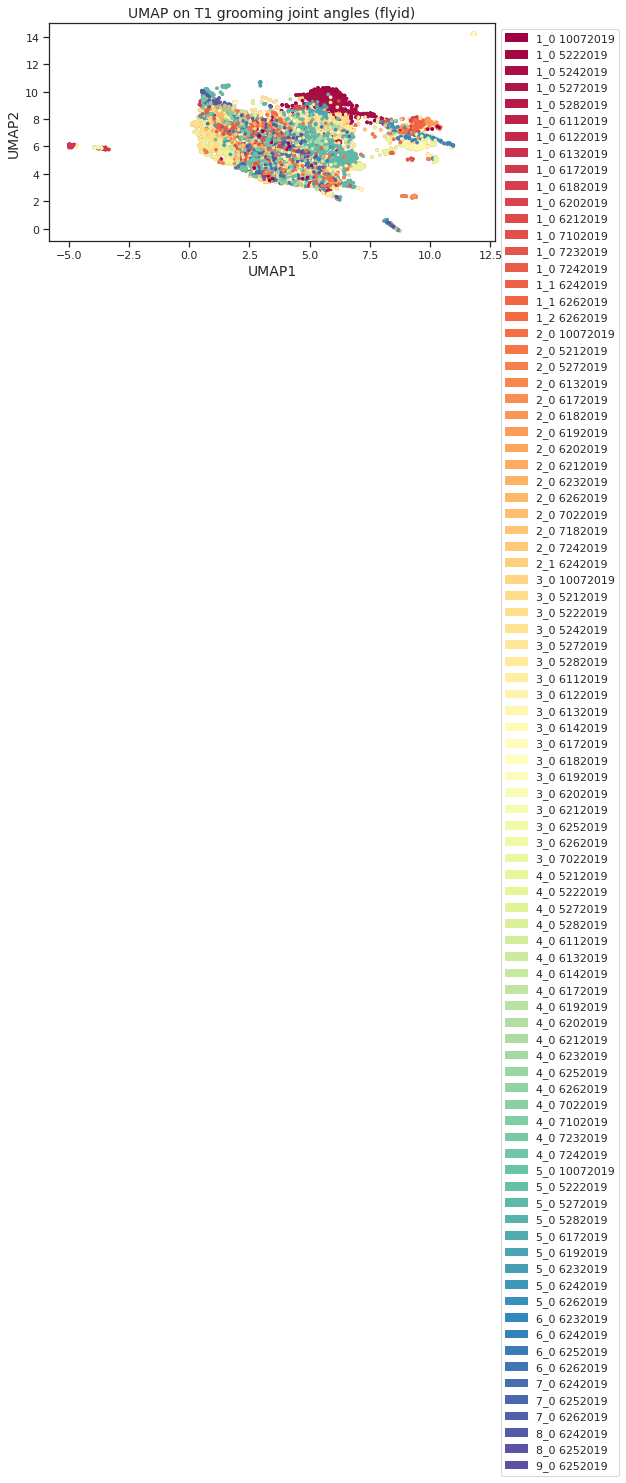

In [8]:
# UMAP: embed according to behavior (only t1 grooming for now), filename,
# bout number, and fly
only_t1 = True
normalize = True
n_components = 2
nperseg = 16
noverlap = int(nperseg // 2)
filenames = np.unique(data.loc[:, 'filename'])
label_types = ['flyid', 'filename', 'behavior_bout']
label_types = ['flyid']

cmap = plt.get_cmap('tab10')
cmap = plt.get_cmap('Spectral')

for j in range(len(label_types)):

    # individual inputs for time and stft features
    X_stft, labels_stft = stft_features(data, data, filenames, label_types[j], fps, nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    # X_times, labels_times = time_features(data, data, filenames, label_types[j], nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    
    # both time and stft features, but could use only the stft or time data/labels
    # X = np.dstack([X_stft[:X_times.shape[0]], X_times])
    # X_in = X.reshape(X.shape[0], -1)
    # labels = labels_stft[:X_times.shape[0]]
    # label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    X_in = X_stft
    X_in = X_in.reshape(X_in.shape[0], -1)
    labels = labels_stft
    label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    # umap
    xmap = umap.UMAP(init='spectral', min_dist=0.2, n_components=n_components, random_state = 1)
    X_map = xmap.fit_transform(X_in)
    plot_xmap(X_map, labels, label_types, fly_dict, cmap, method = 'UMAP')

In [ ]:
# PCA: embed according to behavior (only t1 grooming for now), filename,
# bout number, and fly
only_t1 = True
normalize = True
n_components = 2
nperseg = 16
noverlap = int(nperseg // 2)
filenames = np.unique(data.loc[:, 'filename'])
label_types = ['flyid'] # ['behavior', 'flyid', 'filename', 'behavior_bout']

cmap = plt.get_cmap('tab10')
cmap = plt.get_cmap('Spectral')

for j in range(len(label_types)):

    # individual inputs for time and stft features
    X_stft, labels_stft = stft_features(data, data, filenames, label_types[j], fps, nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    # X_times, labels_times = time_features(data, data, filenames, label_types[j], nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    
    # both time and stft features, but could use only the stft or time data/labels
    # X = np.dstack([X_stft[:X_times.shape[0]], X_times])
    # X_in = X.reshape(X.shape[0], -1)
    # labels = labels_stft[:X_times.shape[0]]
    # label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    X_in = X_stft
    X_in = X_in.reshape(X_in.shape[0], -1)
    labels = labels_stft
    label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    # pca
    pca = PCA(n_components=n_components)
    X_map = pca.fit_transform(X_in)
    explained_variance = pca.explained_variance_ratio_
    singular_values = pca.singular_values_
    plot_xmap(X_map, labels, label_types, fly_dict, cmap, method = 'PCA')

In [ ]:
# TSNE: embed according to behavior (only t1 grooming for now), filename,
# bout number, and fly 
only_t1 = True
normalize = True
n_components = 2
nperseg = 16
noverlap = int(nperseg // 2)
filenames = np.unique(data.loc[:, 'filename'])
label_types = ['flyid'] # ['behavior', 'flyid', 'filename', 'behavior_bout']

cmap = plt.get_cmap('tab10')
cmap = plt.get_cmap('Spectral')

for j in range(len(label_types)):

    # individual inputs for time and stft features
    # X_stft, labels_stft = stft_features(data, data, filenames, label_types[j], fps, nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    X_times, labels_times = time_features(data, data, filenames, label_types[j], nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    
    # both time and stft features, but could use only the stft or time data/labels
    # X = np.dstack([X_stft[:X_times.shape[0]], X_times])
    # X_in = X.reshape(X.shape[0], -1)
    # labels = labels_stft[:X_times.shape[0]]
    # label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    X_in = X_times
    X_in = X_in.reshape(X_in.shape[0], -1)
    labels = labels_times
    label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    # tsne
    tsne = TSNE(n_components=n_components, random_state = 1) 
    # tsne = TSNE(n_components=n_components) 
    X_map = tsne.fit_transform(X_in)
    x_min, x_max = np.min(X_map, 0), np.max(X_map, 0)
    X_map = (X_map - x_min) / (x_max - x_min)   
    plot_xmap(X_map, labels, label_types, fly_dict, cmap, method = 'tSNE')
    